In [1]:
import sys 
sys.path.append("../../../")
from simulation_classes.eta.PathPlanner import PathPlanner

{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 5187.5
CAC_MAX=3575.00, distance=5100.00
PROFILE:  ACD
9
m1の解=12.07
距離:5100.70
[{'ACC': 2, 'duration': 12.06787109375, 'initial_speed': 20}, {'ACC': 0, 'duration': 100.8642578125, 'initial_speed': 44.1357421875}, {'ACC': -2, 'duration': 7.06787109375, 'initial_speed': 44.1357421875}]


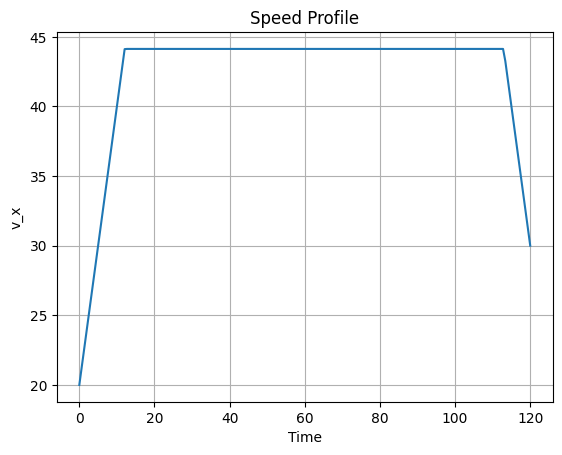

In [3]:
# initial_params
initial_time =20
v_0=20
initial_params = {"time": initial_time, "speed":v_0}

# ideal_params
v_exit = 30
ideal_arrival_time = 140
ideal_params_at_end = {"ideal_arrive_time": ideal_arrival_time, "ideal_speed": v_exit}

# car_spec
max_acc = 2
max_dec = 2
v_max = 45
car_spec = {"max_acc":max_acc, "max_dec":max_dec, "v_max":v_max}

#その他の設計
L_max = 5100

pathPlanner = PathPlanner(car_spec = car_spec, initial_params = initial_params, 
                          ideal_params_at_end=ideal_params_at_end, COURSE_LENGTH = L_max)

x = pathPlanner.solve_path(priority="speed")
pathPlanner.plot_speed_profile()

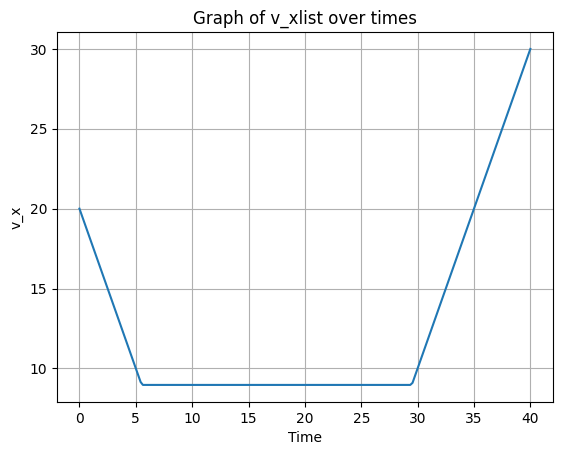

In [4]:
pathPlanner.plot_speed_profile()